
# Classification with the German Traffic Sign Recognition Benchmark.


In [34]:
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Load data and preprocessing

In [2]:
from packages.gtrsb import readTrafficSigns

In [4]:
classes = [3, 7, 13, 14]
tracks = {3: 5, 7: 40, 13: 24, 14: 8}
trainImages, trainDims, trainROIs, trainLabels, filenames = readTrafficSigns('./data', classes, tracks)

120
(30, 29)
((6, 5), (25, 24))
3


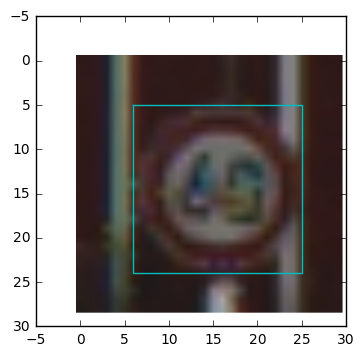

In [5]:
print(len(trainImages))
plt.imshow(trainImages[0]);
print(trainDims[0])
print(trainROIs[0])
roi = trainROIs[0]
p1, p2 = roi
x1, y1 = p1
x2, y2 = p2
plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],'c')
print(trainLabels[0])

In [49]:
from numpy import histogram, interp
def histeq(im,nbr_bins=256):
    imhist, bins = histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize
    im2 = interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape), cdf 

from scipy.misc import imresize
def processImage(img, roi):
    crop_img = img[roi[0][0]:roi[1][0],roi[0][1]:roi[1][1],:]
    planes = crop_img.shape[2]
    sc_img = imresize(crop_img,(20,20,planes))
    R_img = sc_img[:,:,0]
    eq_img, cdf = histeq(R_img)
    return (eq_img-128)/256

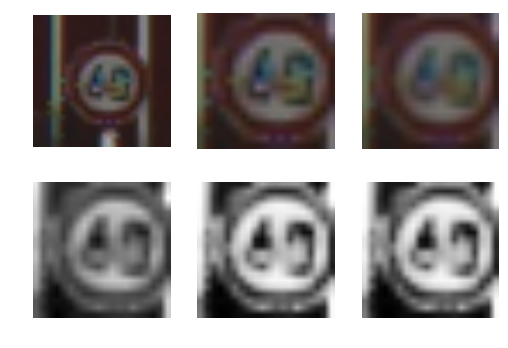

In [48]:
from scipy.misc import imresize

img = trainImages[0]
crop_img = img[x1:x2,y1:y2,:]
#dx, dy = 22,30
dx, dy = 20,20
sc_img = imresize(crop_img, (dx,dy,3))
R_img = sc_img[:,:,0]
eq_img, cdf = histeq(R_img)
norm_img = 2*(eq_img - 128) / 256

plt.subplot(231), plt.imshow(img), plt.axis('off')
plt.subplot(232), plt.imshow(crop_img), plt.axis('off')
plt.subplot(233), plt.imshow(sc_img), plt.axis('off')
plt.subplot(234), plt.imshow(R_img, cmap='gray'), plt.axis('off')
plt.subplot(235), plt.imshow(eq_img, cmap='gray'), plt.axis('off')
plt.subplot(236), plt.imshow(norm_img, cmap='gray'), plt.axis('off');

In [51]:
import numpy as np
X = np.empty(shape=(0,400))
y = []
class_labels=map(str,classes)
for i in range(120):
    eq_img = processImage(trainImages[i],trainROIs[i])
    inpt = eq_img.reshape(1,400)
    target = class_labels.index(trainLabels[i])
    X = np.vstack((X,inpt))
    y.append(target)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

## Build the model and train

In [53]:
net = MLPClassifier(solver='sgd',\
                    hidden_layer_sizes=(50, ),\
                    max_iter=4000)

In [54]:
net.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=4000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Analysis of the network

### Classification report

In [55]:
expected = y_test
predicted = net.predict(X_test)
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      0.86      0.92         7
          1       0.92      1.00      0.96        11
          2       0.94      1.00      0.97        15
          3       1.00      0.93      0.97        15

avg / total       0.96      0.96      0.96        48



### Confusion matrix

In [56]:
print(metrics.confusion_matrix(expected, predicted))

[[ 6  0  1  0]
 [ 0 11  0  0]
 [ 0  0 15  0]
 [ 0  1  0 14]]


### Loss curve

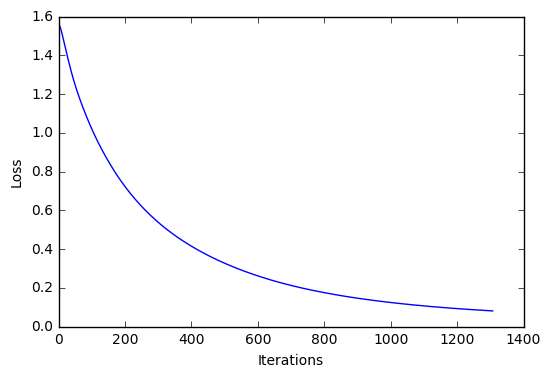

In [40]:
plt.plot(net.loss_curve_);
plt.xlabel('Iterations');
plt.ylabel('Loss');